# Ch6  -> Fine tunning for classification 

In [3]:
import urllib.request
import zipfile
import os
from pathlib import Path 

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
    url, zip_path, expected_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download "
        " and exction.")
    return
with urllib.request.urlopen(url) as response:
    with open(zip_path, "wb") as out_file:
        out_file.write(response.read())
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extracted_path)

original_file_path = Path(extracted_path) / "SMSSpamCollection"
os.rename(original_file_path, data_file_path)
print(f"File dowloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)



File dowloaded and saved as sms_spam_collection/SMSSpamCollection.tsv
sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download  and exction.


In [5]:
!pip install pandas

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 19.9 MB/s  0:00:00eta 0:00:01
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]


In [6]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [9]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    balanced_df = pd.concat([ham_subset, df[df["Label"]== "spam"]])
    return balanced_df
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [10]:
balanced_df["Label"] = balanced_df["Label"].map({"ham":0, "spam":1})

In [12]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(
        frac=1, random_state =123
    ).reset_index(drop=True)
    train_end = int(len(df)* train_frac)
    validation_end = train_end + int(len(df)* validation_frac)
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df,test_df
train_df, validation_df, test_df =random_split(balanced_df, 0.7,0.1)

In [13]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [14]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [16]:
import torch
from torch.utils.data import Dataset
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id= 50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

        self.encoded_texts = [ encoded_text + [pad_token_id] * (self.max_length- len(encoded_text)) for encoded_text in self.encoded_texts]
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype = torch.long)
        )
    def __len__(self):
        return len(self.data)
    def _longest_encoded_length(self):
        max_length =0 
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [17]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

In [18]:
print(train_dataset.max_length)

120


In [20]:
val_dataset = SpamDataset(csv_file  = "validation.csv", max_length=train_dataset.max_length,tokenizer=tokenizer) 
test_dataset = SpamDataset(csv_file="test.csv", max_length= train_dataset.max_length, tokenizer=tokenizer)

In [21]:
from torch.utils.data import DataLoader
num_workers =0 
batch_size = 8
torch.manual_seed(123)
train_loader = DataLoader(dataset=train_dataset, batch_size= batch_size, shuffle =True,
                          num_workers=num_workers, drop_last=True,)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=False,)
test_loader= DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers,drop_last=False,)

for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


In [22]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [25]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size":50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias":True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim":768, "n_layers":12,"n_heads":12},
    "gpt2-medium (355M)" : {"emb_dim":1024, "n_layers":24,"n_heads":16},
    "gpt2-large (774M)" : {"emb_dim":1280, "n_layers":36,"n_heads":20},
    "gpt2-xl (1558M)" : {"emb_dim":1600, "n_layers":48,"n_heads":25},

}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [29]:
from gpt_download import download_and_load_gpt2
from pretaining import GPTModel, load_weights_into_gpt
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size= model_size, models_dir="gpt2")
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [30]:
from gpt import generate_text_simple
from pretaining import text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text_simple(model = model,
                                 idx = text_to_token_ids(text_1, tokenizer),
                                 max_new_tokens=15,
                                 context_size = BASE_CONFIG["context_length"])
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [31]:
text_2 = ("Is the following text 'spam'?  Answer with 'yes' or 'no':"
          " 'You are a winner you have been specially"
          " selected to receive $1000 cash or a $2000 award.")
token_ids = generate_text_simple(model = model,
                                 idx = text_to_token_ids(text_2, tokenizer),
                                 max_new_tokens=23,
                                 context_size = BASE_CONFIG["context_length"])
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'?  Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award. You will be notified when your prize is available. You can choose to receive a prize by email or by phone.


In [33]:
for param in model.parameters():
    param.requires_grad = False

In [34]:
torch.manual_seed(123)
num_classes=2
model.out_head = torch.nn.Linear(
    in_features= BASE_CONFIG["emb_dim"],
    out_features= num_classes
)
for param in model.trf_blocks[-1].parameters():
    param.requires_grad =True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [35]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [36]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [37]:
print("Last output token:", outputs[:,-1,:])

Last output token: tensor([[-3.5983,  3.9902]])


In [38]:
probas = torch.softmax(outputs[:,-1,:], dim =-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


In [39]:
logits = outputs[:,-1,:]
label  = torch.argmax(logits)
print("Class label:",label.item())

Class label: 1


In [41]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches  = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:,-1,:]
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions +=(
                (predicted_labels == target_batch).sum().item()
            )
        else:
            break
    return correct_predictions/num_examples

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Testing accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Testing accuracy: 48.75%


In [43]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:,-1,:]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [ ]:
def calc_loss_loader(data_loader,model, device, num_batches = None):
    total_loss = 0.
    if len(data_loader) ==0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches


In [55]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

    train_acc = calc_accuracy_loader(train_loader, model, device, num_batches=5)
    val_acc = calc_accuracy_loader(val_loader, model, device, num_batches=5)
    test_acc = calc_accuracy_loader(test_loader, model, device, num_batches=5)

print(f"Train loss: {train_loss:.3f}  |  Train acc: {train_acc*100:.2f}%")
print(f"Val   loss: {val_loss:.3f}  |  Val   acc: {val_acc*100:.2f}%")
print(f"Test  loss: {test_loss:.3f}  |  Test  acc: {test_acc*100:.2f}%")

Train loss: 0.245  |  Train acc: 87.50%
Val   loss: 0.204  |  Val   acc: 92.50%
Test  loss: 0.417  |  Test  acc: 87.50%


In [62]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        model.train()
    return train_loss, val_loss

def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device, num_epochs,
        eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step +=1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}):"
                      f"Train loss {train_loss: .3f},"
                      f"Val loss {val_loss: .3f}")
                train_accuracy = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
                val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches= eval_iter)
                print(f"Trainig accuracy: {train_accuracy*100 : .2f}% | ", end=" ")
                print(f"Validation accuracy: {val_accuracy*100:.2f}%")
                train_accs.append(train_accuracy)
                val_accs.append(val_accuracy)
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [63]:
import time 
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5, weight_decay= 0.1)
num_epochs =5
train_losses, val_losses, train_accs, val_accs, example_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50,
    eval_iter=5
)
end_time = time.time()
exceution_time_minutes = (end_time - start_time)/60
print(f"Training completed in {exceution_time_minutes: .2f} minutes")

Ep 1 (Step 000000):Train loss  0.975,Val loss  0.975
Trainig accuracy:  1.75% |  Validation accuracy: 97.50%
Ep 1 (Step 000050):Train loss  0.950,Val loss  0.975
Trainig accuracy:  1.31% |  Validation accuracy: 97.50%
Ep 1 (Step 000100):Train loss  0.975,Val loss  0.975
Trainig accuracy:  1.15% |  Validation accuracy: 97.50%
Ep 2 (Step 000150):Train loss  1.000,Val loss  0.975
Trainig accuracy:  4.62% |  Validation accuracy: 97.50%
Ep 2 (Step 000200):Train loss  0.950,Val loss  0.950
Trainig accuracy:  11.16% |  Validation accuracy: 95.00%
Ep 2 (Step 000250):Train loss  1.000,Val loss  0.975
Trainig accuracy:  0.45% |  Validation accuracy: 97.50%
Ep 3 (Step 000300):Train loss  0.975,Val loss  0.975
Trainig accuracy:  1.73% |  Validation accuracy: 97.50%
Ep 3 (Step 000350):Train loss  0.975,Val loss  0.950
Trainig accuracy:  2.05% |  Validation accuracy: 95.00%
Ep 4 (Step 000400):Train loss  1.000,Val loss  0.975
Trainig accuracy:  10.29% |  Validation accuracy: 97.50%
Ep 4 (Step 000450

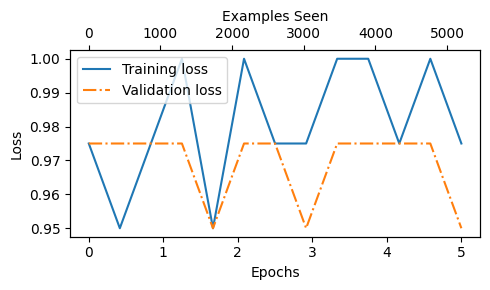

In [64]:
import matplotlib.pyplot as plt
def plot_values(
        epochs_seen, example_seen, train_values, val_values, label = "loss"):
    fig, ax1 = plt.subplots(figsize = (5,3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle ="-.",
             label = f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    ax2 = ax1.twiny()
    ax2.plot(example_seen, train_values, alpha =0 )
    ax2.set_xlabel("Examples Seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
example_seen_tensor = torch.linspace(0, example_seen, len(train_losses))
plot_values(epochs_tensor, example_seen_tensor, train_losses, val_losses )


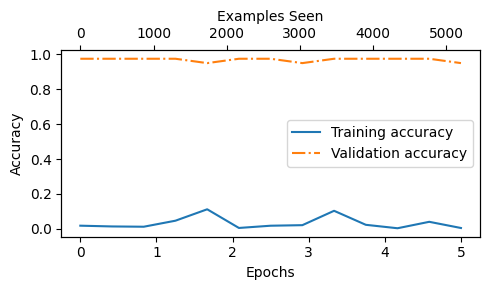

In [66]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
example_seen_tensor = torch.linspace(0, example_seen, len(train_accs))
plot_values(epochs_tensor, example_seen_tensor, train_accs, val_accs, label="accuracy")

In [68]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100: .2f}")
print(f"Validation accuracy: {val_accuracy*100: .2f}")
print(f"Test accuracy: {test_accuracy*100: .2f}")

Training accuracy:  99.04
Validation accuracy:  97.32
Test accuracy:  95.00


In [69]:
def classify_review(text, model, tokenizer, device, max_length = None,
                    pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]
    input_ids = input_ids[:min(max_length, supported_context_length)]
    input_ids +=[pad_token_id]*(max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device = device).unsqueeze(0)
    with torch.no_grad():
        logits = model(input_tensor)[:,-1,:]
    predicted_label = torch.argmax(logits, dim=-1).item()
    return "spam" if predicted_label == 1 else "not spam"

In [70]:
text_1 = (
    "You are winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)
print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [71]:
text_2 = (
    "Hey, just wanted to hech if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


In [72]:
torch.save(model.state_dict(),"review_classifier.pth")

In [77]:
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>